
# packages 

In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm
from typing import List, Optional
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from IPython.display import FileLink
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import shutil
import skimage
from PIL import Image, ImageDraw
import random
from skimage import io

tqdm.pandas()

# data resizing 


In [ ]:
ROOT_DIR = "/kaggle/working/"

TRAIN_DATAFRAMES = "/kaggle/input/deepfashion2-original-with-dataframes/DeepFashion2/img_info_dataframes/train.csv"
VALIDATION_DATAFRAMES = "/kaggle/input/deepfashion2-original-with-dataframes/DeepFashion2/img_info_dataframes/validation.csv"
TEST_DATAFRAMES = "/kaggle/input/deepfashion2-original-with-dataframes/DeepFashion2/img_info_dataframes/test.csv"

In [ ]:
train_df = pd.read_csv(TRAIN_DATAFRAMES)
validation_df = pd.read_csv(VALIDATION_DATAFRAMES)
test_df = pd.read_csv(TEST_DATAFRAMES)

In [ ]:
train_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(22,10))
sns.countplot(y='category_name', data=train_df, order=train_df['category_name'].value_counts().index)
plt.title('Distribution of Clothing Categories')
plt.show()

In [ ]:
validation_df['segmentation'] = validation_df['segmentation'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))
train_df['segmentation'] = train_df['segmentation'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))

In [ ]:
validation_df['b_box'] = validation_df['b_box'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))
train_df['b_box'] = train_df['b_box'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))

In [ ]:
validation_df['landmarks'] = validation_df['landmarks'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))
train_df['landmarks'] = train_df['landmarks'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))

In [ ]:
RESIZED_TARGET_DIRECTORY = ROOT_DIR + "resized/"
TARGET_DIR = ROOT_DIR + "input/"
os.makedirs(os.path.join(RESIZED_TARGET_DIRECTORY, "train"))
os.makedirs(os.path.join(RESIZED_TARGET_DIRECTORY, "validation"))
os.makedirs(os.path.join(RESIZED_TARGET_DIRECTORY, "test"))
os.makedirs(TARGET_DIR)

In [ ]:


TARGET_SIZE = (224, 336)
def resize_bbox(bbox, x_scale, y_scale):
    if len(bbox) == 4:
        return [bbox[0] * x_scale, bbox[1] * y_scale, bbox[2] * x_scale, bbox[3] * y_scale]
    return bbox

def resize_segmentation(segmentation, x_scale, y_scale):
    resized_segmentation = []
    for polygon in segmentation:
        if len(polygon) % 2 == 0:
            resized_polygon = []
            for i in range(0, len(polygon), 2):
                x = polygon[i] * x_scale
                y = polygon[i + 1] * y_scale
                resized_polygon.extend([x, y])
            resized_segmentation.append(resized_polygon)
    return resized_segmentation

def resize_landmarks(landmarks, x_scale, y_scale):
    resized_landmarks = []
    if len(landmarks) % 3 == 0:
        for i in range(0, len(landmarks), 3):
            x = landmarks[i] * x_scale
            y = landmarks[i + 1] * y_scale
            v = landmarks[i + 2]  # visibility remains the same
            resized_landmarks.extend([x, y, v])
    return resized_landmarks

def resize_image_and_annotations(row):
    try:
        # Creating path for the resized image
        img_path = row['path']
        name_list = img_path.split("/")
        df_type = name_list[-3]
        new_img_path = os.path.join(RESIZED_TARGET_DIRECTORY, df_type, name_list[-1]) 
        
        # Reading & resizing the image; saving resized image into new folder
        image = cv2.imread(img_path)
        original_height, original_width = image.shape[:2]
        resized_image = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_AREA)
        cv2.imwrite(new_img_path, resized_image)
        
        # Calculate the scaling factors
        x_scale = TARGET_SIZE[0] / original_width
        y_scale = TARGET_SIZE[1] / original_height
        
        if df_type != "test":
            # Resize the bounding box, segmentation, and landmarks
            bbox = row['b_box']
            segmentation = row['segmentation']
            landmarks = row.get('landmarks', [])
            
            resized_bbox = resize_bbox(bbox, x_scale, y_scale)
            resized_segmentation = resize_segmentation(segmentation, x_scale, y_scale)
            resized_landmarks = resize_landmarks(landmarks, x_scale, y_scale)
            
            # Update the dataframe row with annotations
            row['b_box'] = resized_bbox
            row['segmentation'] = resized_segmentation
            row['landmarks'] = resized_landmarks
        
        # Update the dataframe row with new image path and dimensions
        row['path'] = new_img_path
        row['img_height'] = TARGET_SIZE[1]
        row['img_width'] = TARGET_SIZE[0]

    except Exception as e:
        print(f"Error processing row: {e}")
        
    return row

In [ ]:
train_df_resized = train_df.progress_apply(resize_image_and_annotations, axis=1)
validation_df_resized = validation_df.progress_apply(resize_image_and_annotations, axis=1)
test_df_resized = test_df.progress_apply(resize_image_and_annotations, axis=1)

In [ ]:
train_df_resized.to_csv(TARGET_DIR + "train.csv", index=False)
validation_df_resized.to_csv(TARGET_DIR + "validation.csv", index=False)
test_df_resized.to_csv(TARGET_DIR + "test.csv", index=False)

# preparing data for all categories 
In this section, we created the data in the appropriate format for YOLO to train. The same code is used for the 13 categories, with just the category name being changed. I will provide the code for the 'trousers' category.

In [ ]:
  # Replace with your dataset path
image_dir = '/kaggle/input/data-resi/resized/train'       # Replace with your images directory path
filtered_image_dir = '/kaggle/working/'  # Directory to save filtered images

# Filter the dataset to include only images of the category "trousers"
filtered_df_train = trainre_df[trainre_df['category_name'] == 'trousers']

# Create the directory for filtered images if it does not exist
if not os.path.exists(filtered_image_dir):
    os.makedirs(filtered_image_dir)


# Nouveau chemin de base pour les images
new_base_path1 = '/kaggle/input/data-resi/resized/train'

# Mettre à jour les chemins dans la colonne `path`
filtered_df_train['path'] = filtered_df_train['path'].apply(lambda x: os.path.join(new_base_path1, os.path.basename(x)))
# Save the filtered dataset to a new CSV file
filtered_data_path = 'filtered_trousers_dataset_train.csv'
filtered_df_train.to_csv(filtered_data_path, index=False)
print(f'Filtered dataset saved to {filtered_data_path}')
print(f'Number of images in filtered dataset: {len(filtered_df_train)}')
print(f'Filtered images saved to {filtered_image_dir}')

In [ ]:
 # Replace with your dataset path
image_dir = '/kaggle/input/data-resi/resized/validation'       # Replace with your images directory path
filtered_image_dir = '/kaggle/working/'  # Directory to save filtered images

# Filter the dataset to include only images of the category "trousers"
filtered_df_valid = validationre_df[validationre_df['category_name'] == 'trousers']

# Create the directory for filtered images if it does not exist
if not os.path.exists(filtered_image_dir):
    os.makedirs(filtered_image_dir)

new_base_path2 = '/kaggle/input/data-resi/resized/validation'

# Mettre à jour les chemins dans la colonne `path`
filtered_df_valid['path'] = filtered_df_valid['path'].apply(lambda x: os.path.join(new_base_path2, os.path.basename(x)))

# Save the filtered dataset to a new CSV file
filtered_data_path_valid = 'filtered_trousers_dataset_valid.csv'
filtered_df_valid.to_csv(filtered_data_path_valid, index=False)

print(f'Filtered dataset saved to {filtered_data_path_valid}')
print(f'Number of images in filtered dataset: {len(filtered_df_valid)}')
print(f'Filtered images saved to {filtered_image_dir}')

In [ ]:
# Fonction pour visualiser une image avec ses landmarks
def visualize_image_with_landmarks(df, index):
    row = df.iloc[index]
    image_path = row['path']
    landmarks = eval(row['landmarks'])
    
    # Lire l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Afficher l'image
    plt.imshow(image)
    
    # Tracer les landmarks
    for i in range(0, len(landmarks), 3):
        x = landmarks[i]
        y = landmarks[i + 1]
        plt.scatter(x, y, color='white')
    
    plt.title(f"Image with Landmarks - {image_path}")
    plt.show()

# Visualiser une image avec ses landmarks (par exemple, la première image)
visualize_image_with_landmarks(filtered_df_train, 5)

In [ ]:
from PIL import Image
import shutil

# Define paths to CSV files and base directory
train_csv_path = '/kaggle/working/filtered_trousers_dataset_train.csv'
val_csv_path = '/kaggle/working/filtered_trousers_dataset_valid.csv'
image_base_path = '/kaggle/input/data-resi/resized'  # Base directory for images
base_dir = '/kaggle/working/'  # Base directory for data

# Define paths for the new directory structure
train_images_path = os.path.join(base_dir, 'images', 'train')
val_images_path = os.path.join(base_dir, 'images', 'validation')
train_labels_path = os.path.join(base_dir, 'labels', 'train')
val_labels_path = os.path.join(base_dir, 'labels', 'validation')

# Create directories if they don't exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)

# Function to normalize coordinates
def normalize(value, max_value):
    return value / max_value

# Function to convert bounding box and landmarks to YOLO format
def convert_to_yolo_format(row, image_width, image_height):
    image_id = row['path'].split('/')[-1].split('.')[0]  # Extract image ID from path
    b_box = eval(row['b_box'])
    landmarks = eval(row['landmarks'])
    
    # Convert bounding box to YOLO format: (center_x, center_y, width, height)
    x_center = (b_box[0] + b_box[2]) / 2
    y_center = (b_box[1] + b_box[3]) / 2
    width = b_box[2] - b_box[0]
    height = b_box[3] - b_box[1]
    
    # Normalize bounding box coordinates
    x_center = normalize(x_center, image_width)
    y_center = normalize(y_center, image_height)
    width = normalize(width, image_width)
    height = normalize(height, image_height)
    
    yolo_bbox = [x_center, y_center, width, height]
    
    # Prepare and normalize landmarks in the format: [x1, y1, v1, ..., x14, y14, v14]
    yolo_landmarks = []
    for i in range(0, len(landmarks), 3):
        x = normalize(landmarks[i], image_width)
        y = normalize(landmarks[i+1], image_height)
        v = landmarks[i+2]
        yolo_landmarks.extend([x, y, v])
    
    return image_id, yolo_bbox, yolo_landmarks

# Function to save YOLO labels to file
def save_yolo_labels(image_id, yolo_bbox, yolo_landmarks, labels_path):
    with open(os.path.join(labels_path, f"{image_id}.txt"), 'w') as f:
        bbox_str = ' '.join(map(str, yolo_bbox))
        landmarks_str = ' '.join(map(str, yolo_landmarks))
        f.write(f"0 {bbox_str} {landmarks_str}\n")  # Class ID is 0

# Process CSV files and generate labels and copy images
for csv_path, labels_path, images_path in zip(
    [train_csv_path, val_csv_path], 
    [train_labels_path, val_labels_path], 
    [train_images_path, val_images_path]):
    
    df = pd.read_csv(csv_path)
    for _, row in df.iterrows():
        # Load the image to get its dimensions
        image_path = os.path.join(image_base_path, row['path'])
        with Image.open(image_path) as img:
            image_width, image_height = img.size
        
        image_id, yolo_bbox, yolo_landmarks = convert_to_yolo_format(row, image_width, image_height)
        save_yolo_labels(image_id, yolo_bbox, yolo_landmarks, labels_path)
        
        # Copy image to the new directory
        shutil.copy(image_path, os.path.join(images_path, f"{image_id}.jpg"))

# the YAML files

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-trousiers
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [14, 3]  # [number of keypoints, number of dim]
flip_idx: [2,1,0,13,12,11,10,9,8,7,6,5,4,3]

# Classes
names:
  0: trousers
"""

with open('/kaggle/working/datatrou.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-shorts
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [10, 3]  # [number of keypoints, number of dim]
flip_idx: [2, 1, 0, 9, 8, 7, 6, 5, 4, 3]

# Classes
names:
  0: shorts
"""

with open('/kaggle/working/datashorts.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-skirt
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [8, 3]  # [number of keypoints, number of dim]
flip_idx: [2, 1, 0, 7, 6, 5, 4, 3]



# Classes
names:
  0: skirt
"""

with open('/kaggle/working/dataskirt.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-long-sleeve-top
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [33, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 3, 2, 1, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]


# Classes
names:
  0: long sleeve top
"""

with open('/kaggle/working/datalong-sleeve-top.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-vest-dress
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [19, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 3, 2, 1, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7,6]


# Classes
names:
  0: vest dress
"""

with open('/kaggle/working/data-vest-dress.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-sling-dress
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [19, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 3, 2, 1, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]


# Classes
names:
  0: sling dress
"""

with open('/kaggle/working/data-sling-dress.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-short-sleeve-dress
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [29, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 3, 2, 1, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]


# Classes
names:
  0: short sleeve dress
"""

with open('/kaggle/working/data-short_sleeve-dress.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-long-sleeve-dress
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [37, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 3, 2, 1, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,13,12,11,10,9,8,7,6]


# Classes
names:
  0: long sleeve dress
"""

with open('/kaggle/working/data-long_sleeve-dress.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-vest
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [15, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 3, 2, 1, 14, 13, 12, 11, 10, 9, 8, 7, 6]


# Classes
names:
  0: vest
"""

with open('/kaggle/working/data-vest.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-short-sleeve-top
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [25, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 3, 2, 1, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]


# Classes
names:
  0: short sleeve top
"""

with open('/kaggle/working/data-short sleeve top.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-long-sleeve-outwear
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [39, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 33, 2, 1, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 36, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 3, 37, 38, 19, 34, 35]

# Classes
names:
  0: long sleeve outwear
"""

with open('/kaggle/working/data_long_sleeve_outwear.yaml', 'w') as f:
    f.write(data_yaml)


In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-long-sleeve-top
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [33, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 3, 2, 1, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]


# Classes
names:
  0: long sleeve top
"""

with open('/kaggle/working/datalong-sleeve-top.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
data_yaml = """
# Data
path: /kaggle/input/data-sling
train: images/train  # train images (relative to 'path')
val: images/validation  # val images (relative to 'path')

# Keypoints
kpt_shape: [15, 3]  # [number of keypoints, number of dim]
flip_idx: [0, 5, 4, 3, 2, 1, 14, 13, 12, 11, 10, 9, 8, 7, 6]


# Classes
names:
  0: sling
"""

with open('/kaggle/working/data-sling.yaml', 'w') as f:
    f.write(data_yaml)

# model training for landmarks detection

In [2]:
!pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.4/869.4 kB 19.2 MB/s eta 0:00:0000:01


The training process varies from one category to another, depending on the amount and quality of the data. The basic code I used remains consistent, but the number of epochs and the initial learning rate differ for each category. For most categories, I worked with at least 50 epochs

In [ ]:
import torch
from ultralytics import YOLO
model = YOLO('yolov8n-pose.pt')  # load a pretrained model (recommended for training)
results = model.train(data='/kaggle/working/data-sling.yaml',
                      epochs=50,   
                      imgsz=224,    
                      lr0=0.001,     # initial learning rate
                      lrf=0.01,      # Final learning rate
                      optimizer='Adam', # Optimizer

)


some results of the models


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/101.png: 224x160 1 long sleeve outwear, 33.7ms
Speed: 0.7ms preprocess, 33.7ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 160)


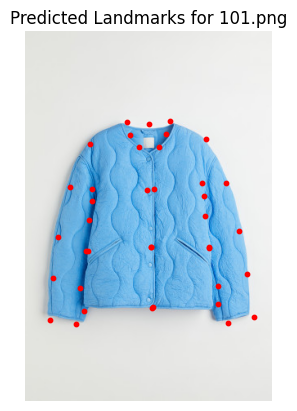


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/116.png: 224x160 1 long sleeve outwear, 31.0ms
Speed: 0.7ms preprocess, 31.0ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 160)


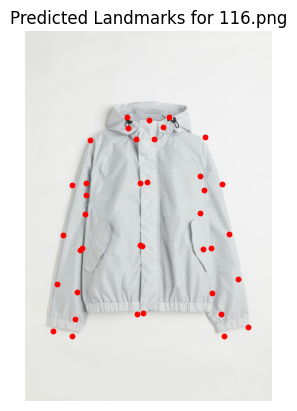


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/129.png: 224x160 1 long sleeve outwear, 30.1ms
Speed: 0.7ms preprocess, 30.1ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


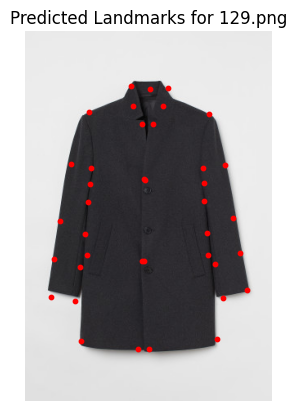


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/140.png: 224x160 1 long sleeve outwear, 31.3ms
Speed: 0.7ms preprocess, 31.3ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


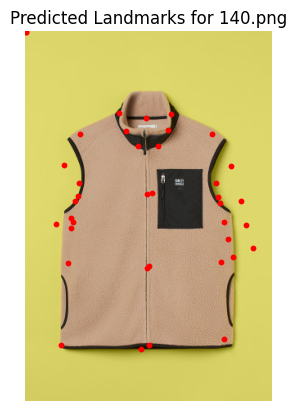


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/148.png: 224x160 1 long sleeve outwear, 33.0ms
Speed: 0.7ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 160)


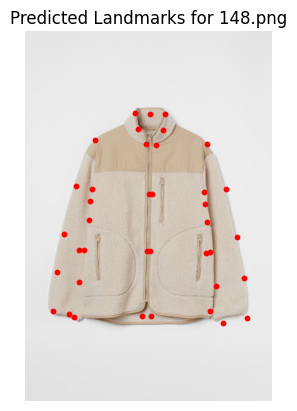


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/159.png: 224x160 1 long sleeve outwear, 32.8ms
Speed: 0.7ms preprocess, 32.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 160)


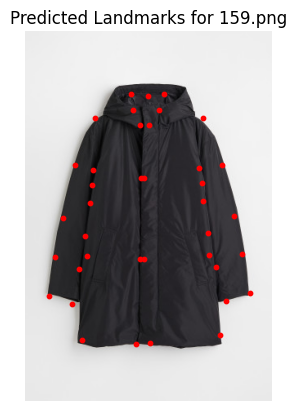


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/162.png: 224x160 1 long sleeve outwear, 32.4ms
Speed: 0.7ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 160)


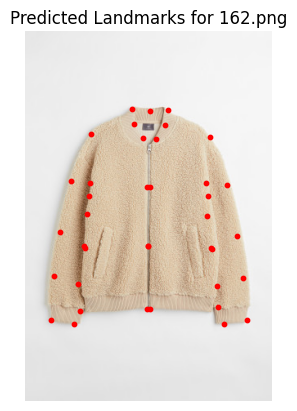


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/173.png: 224x160 1 long sleeve outwear, 32.7ms
Speed: 0.7ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 160)


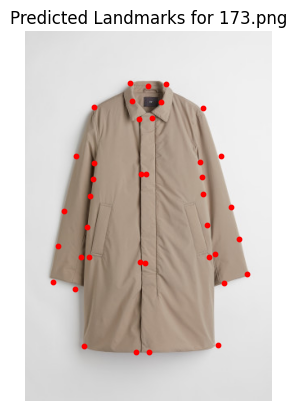


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/174.png: 224x160 1 long sleeve outwear, 30.3ms
Speed: 0.7ms preprocess, 30.3ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


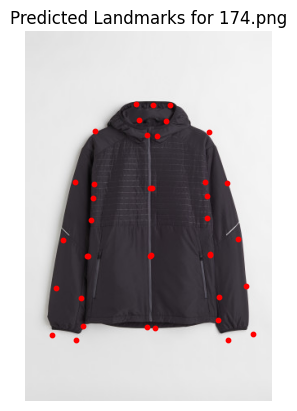


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/182.png: 224x160 1 long sleeve outwear, 30.9ms
Speed: 0.8ms preprocess, 30.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


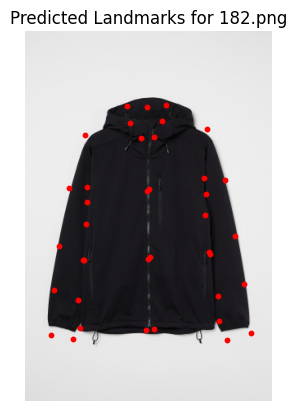


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/183.png: 224x160 1 long sleeve outwear, 29.7ms
Speed: 0.8ms preprocess, 29.7ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 160)


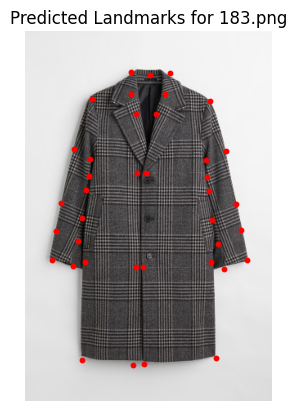


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/22.png: 224x160 1 long sleeve outwear, 30.0ms
Speed: 0.7ms preprocess, 30.0ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


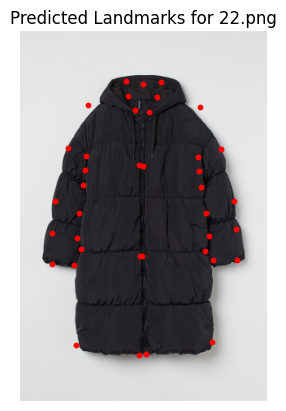


image 1/1 /kaggle/input/outfititems/val/val/upperwear/jacket/35.png: 224x160 1 long sleeve outwear, 32.5ms
Speed: 0.9ms preprocess, 32.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 160)


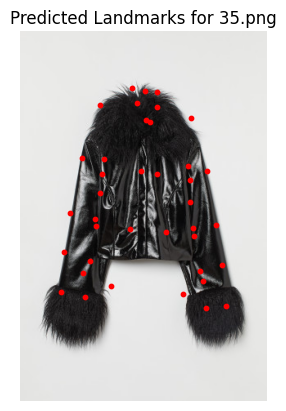

In [21]:
from ultralytics import YOLO
# Define paths
model_path = '/kaggle/input/model_long_sleeve_outwear/pytorch/100/1/best(37).pt'
image_dir = '/kaggle/input/outfititems/val/val/upperwear/jacket'

# Get the list of image files
image_files = [
    "101.png",
    "116.png",
    "129.png",
  
    "148.png",
    "159.png",
    "162.png",
    "173.png",
    "174.png",
    "182.png",
    "183.png",
    "22.png",
    "35.png"

]

# Load the YOLO model
model = YOLO(model_path)

# Predict and visualize the results for the first 10 images
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    
    # Load image
    img = cv2.imread(image_path)
    
    # Run the YOLO model
    results = model(image_path)[0]
    
    # Visualize the results
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    
    for result in results:
        for keypoint in result.keypoints.data.tolist()[0]:
            plt.scatter(keypoint[0], keypoint[1], s=10, c='red', marker='o')  # Plot the keypoints
    
    plt.title(f'Predicted Landmarks for {image_file}')
    plt.axis('off')
    plt.show()


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10002.png: 224x192 1 short sleeve top, 32.1ms
Speed: 0.8ms preprocess, 32.1ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


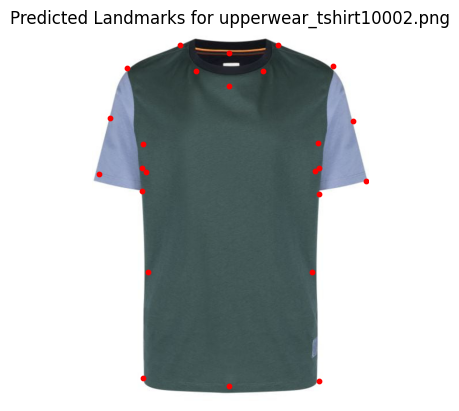


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10005.png: 224x192 1 short sleeve top, 33.1ms
Speed: 0.8ms preprocess, 33.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


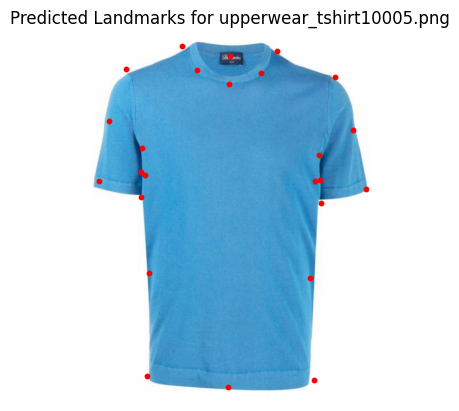


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10013.png: 224x192 1 short sleeve top, 32.9ms
Speed: 0.9ms preprocess, 32.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


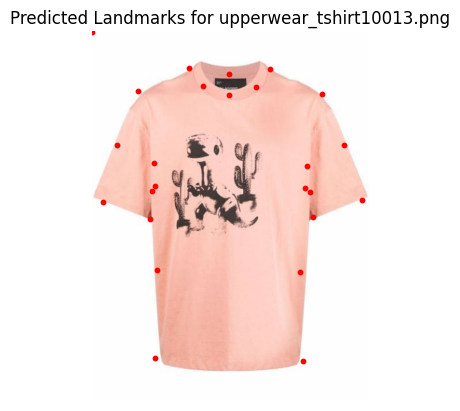


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10024.png: 224x192 1 short sleeve top, 29.8ms
Speed: 0.8ms preprocess, 29.8ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


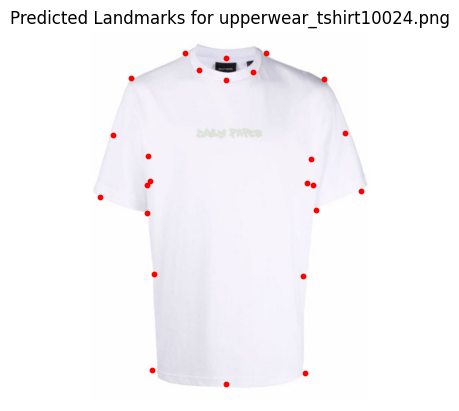


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10043.png: 224x192 1 short sleeve top, 33.0ms
Speed: 0.8ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


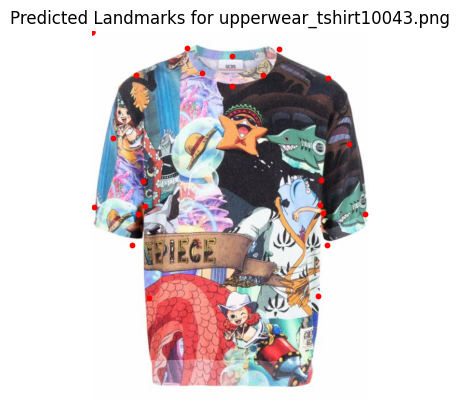


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10046.png: 224x192 1 short sleeve top, 32.8ms
Speed: 0.8ms preprocess, 32.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 192)


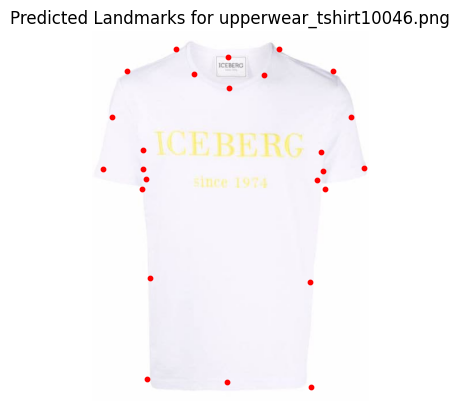


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10063.png: 224x192 1 short sleeve top, 32.4ms
Speed: 0.8ms preprocess, 32.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


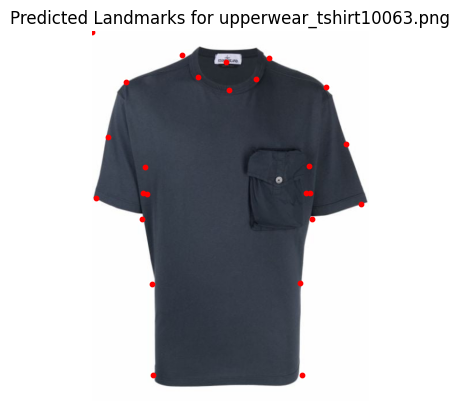


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10074.png: 224x192 1 short sleeve top, 32.0ms
Speed: 0.8ms preprocess, 32.0ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


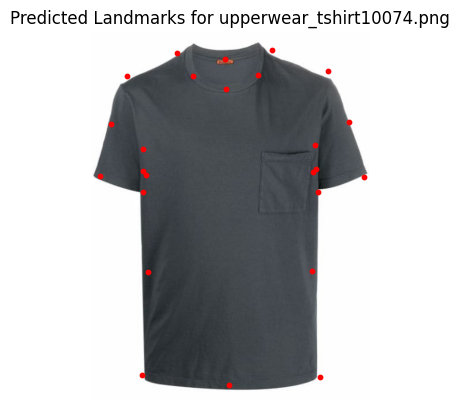


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10077.png: 224x192 1 short sleeve top, 30.7ms
Speed: 0.8ms preprocess, 30.7ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


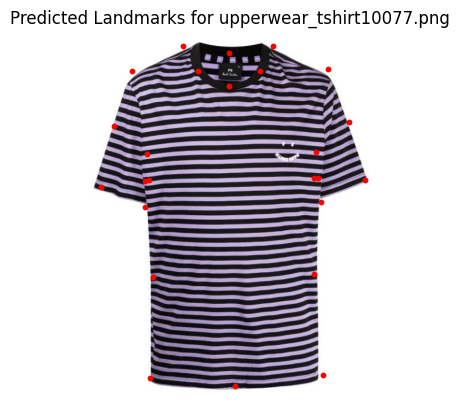


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10150.png: 224x192 1 short sleeve top, 29.9ms
Speed: 0.8ms preprocess, 29.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


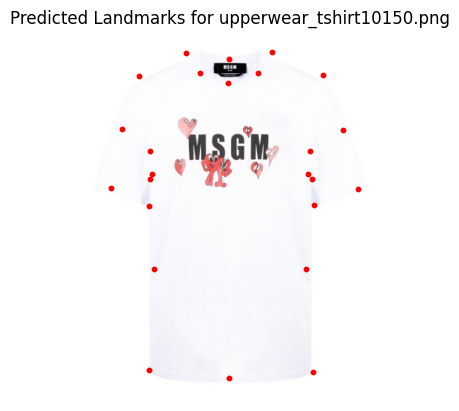


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10182.png: 224x192 1 short sleeve top, 30.8ms
Speed: 0.8ms preprocess, 30.8ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


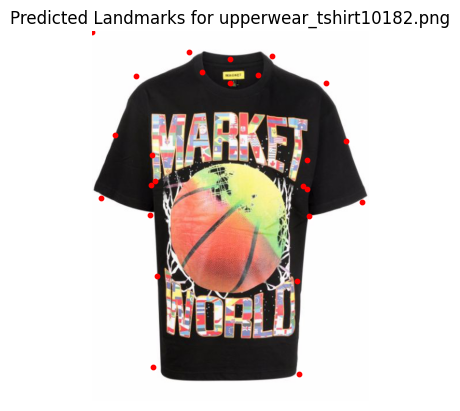


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10184.png: 224x192 1 short sleeve top, 29.9ms
Speed: 0.9ms preprocess, 29.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


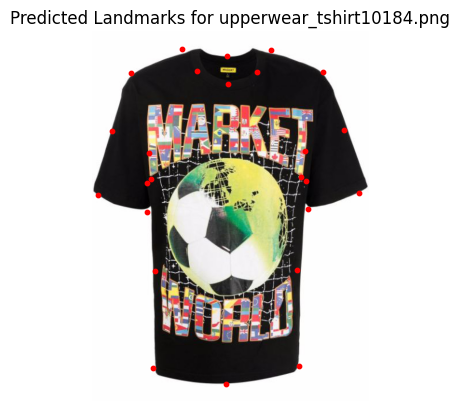


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10190.png: 224x192 1 short sleeve top, 29.4ms
Speed: 0.8ms preprocess, 29.4ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


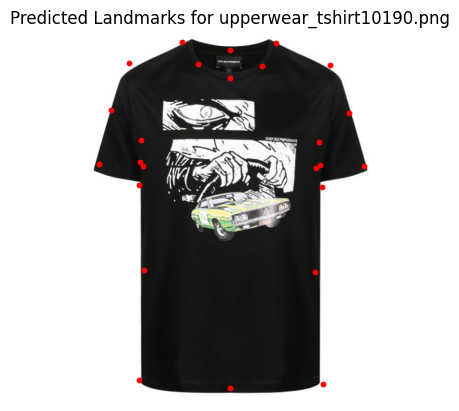


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10204.png: 224x192 1 short sleeve top, 34.3ms
Speed: 0.8ms preprocess, 34.3ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 192)


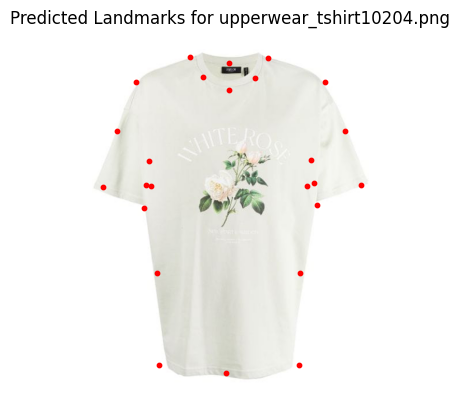


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10205.png: 224x192 1 short sleeve top, 30.0ms
Speed: 0.8ms preprocess, 30.0ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


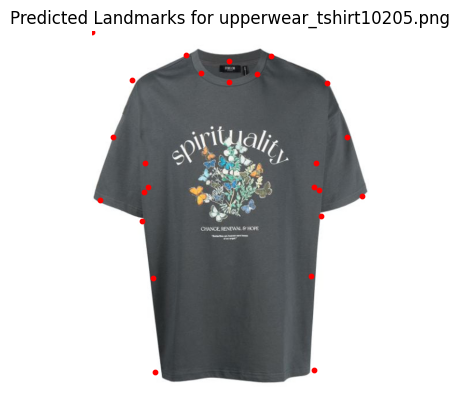


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10209.png: 224x192 1 short sleeve top, 33.7ms
Speed: 0.8ms preprocess, 33.7ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


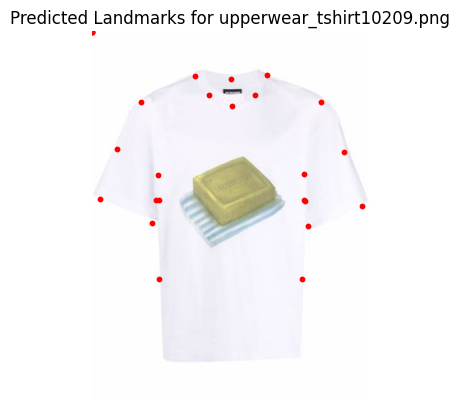


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt1021.png: 224x192 1 short sleeve top, 34.2ms
Speed: 0.8ms preprocess, 34.2ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


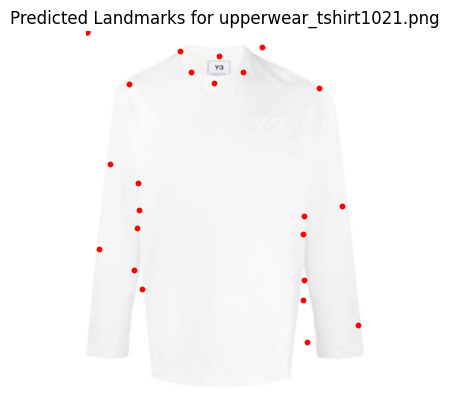


image 1/1 /kaggle/input/outfititems/val/val/upperwear/tshirt/upperwear_tshirt10229.png: 224x192 1 short sleeve top, 33.7ms
Speed: 0.8ms preprocess, 33.7ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


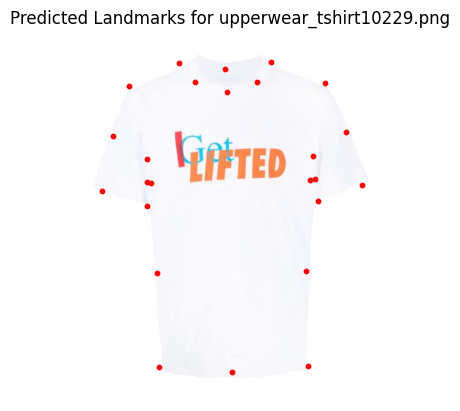

In [15]:
from ultralytics import YOLO
# Define paths
model_path = '/kaggle/input/model_short_sleeve_top/pytorch/50_epoch/1/best(36).pt'
image_dir = '/kaggle/input/outfititems/val/val/upperwear/tshirt'

# Get the list of image files
image_files = [
    "upperwear_tshirt10002.png",
    "upperwear_tshirt10005.png",
    "upperwear_tshirt10013.png",
    "upperwear_tshirt10024.png",
    "upperwear_tshirt10043.png",
    "upperwear_tshirt10046.png",
    "upperwear_tshirt10063.png",
    "upperwear_tshirt10074.png",
    "upperwear_tshirt10077.png",
    "upperwear_tshirt10150.png",
    "upperwear_tshirt10182.png",
    "upperwear_tshirt10184.png",
    "upperwear_tshirt10190.png",
    "upperwear_tshirt10204.png",
    "upperwear_tshirt10205.png",
    "upperwear_tshirt10209.png",
    "upperwear_tshirt1021.png",
    "upperwear_tshirt10229.png",
]

# Load the YOLO model
model = YOLO(model_path)

# Predict and visualize the results for the first 10 images
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    
    # Load image
    img = cv2.imread(image_path)
    
    # Run the YOLO model
    results = model(image_path)[0]
    
    # Visualize the results
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    
    for result in results:
        for keypoint in result.keypoints.data.tolist()[0]:
            plt.scatter(keypoint[0], keypoint[1], s=10, c='red', marker='o')  # Plot the keypoints
    
    plt.title(f'Predicted Landmarks for {image_file}')
    plt.axis('off')
    plt.show()


0: 224x192 1 long sleeve top, 41.1ms
Speed: 1.2ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


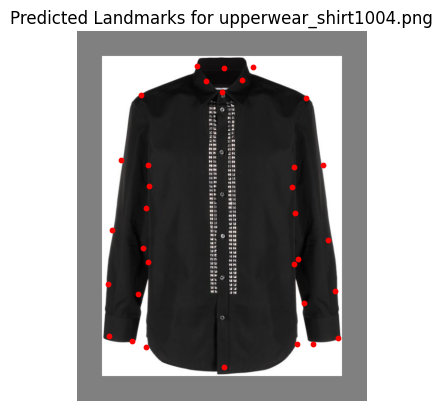


0: 224x192 1 long sleeve top, 33.9ms
Speed: 1.0ms preprocess, 33.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


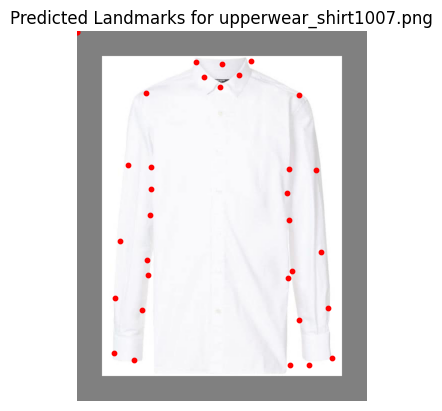


0: 224x192 1 long sleeve top, 35.1ms
Speed: 1.0ms preprocess, 35.1ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 192)


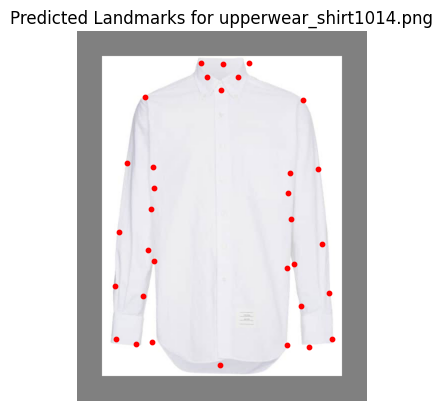


0: 224x192 1 long sleeve top, 35.4ms
Speed: 1.2ms preprocess, 35.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


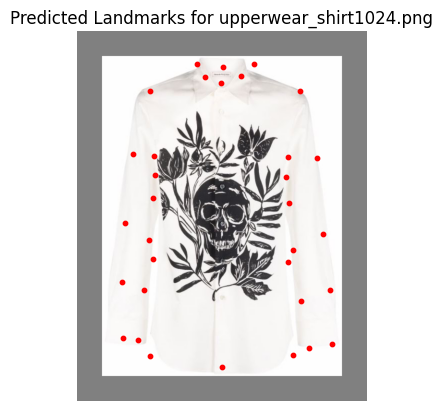


0: 224x192 1 long sleeve top, 35.9ms
Speed: 4.5ms preprocess, 35.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


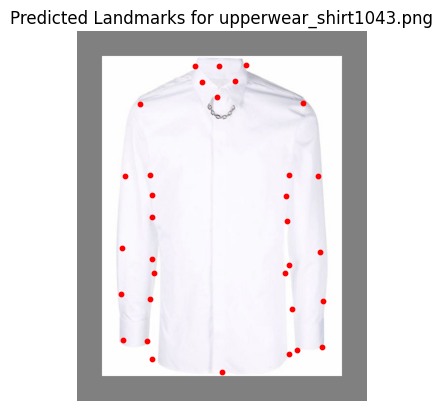


0: 224x192 1 long sleeve top, 39.3ms
Speed: 1.0ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


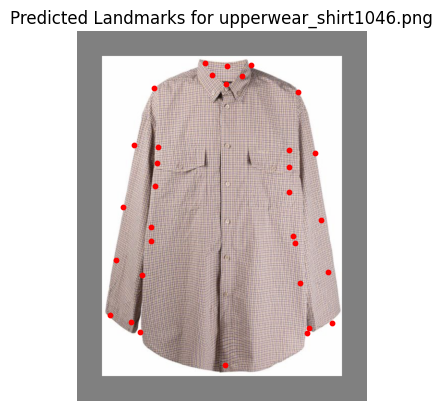


0: 224x192 1 long sleeve top, 33.9ms
Speed: 1.1ms preprocess, 33.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


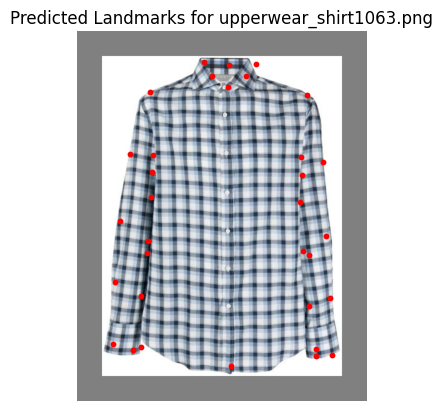


0: 224x192 1 long sleeve top, 35.6ms
Speed: 1.1ms preprocess, 35.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


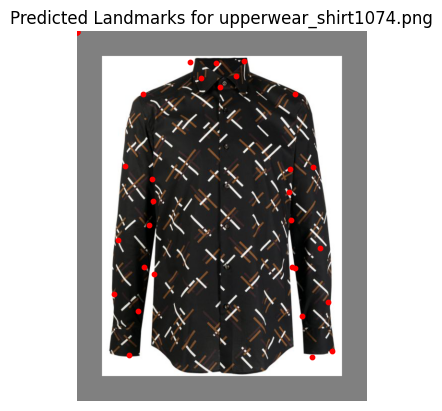


0: 224x192 1 long sleeve top, 35.8ms
Speed: 1.2ms preprocess, 35.8ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


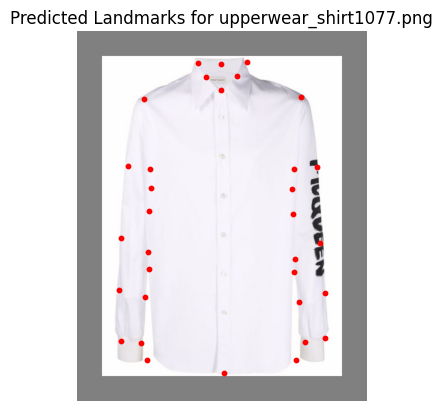


0: 224x192 1 long sleeve top, 36.3ms
Speed: 0.9ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


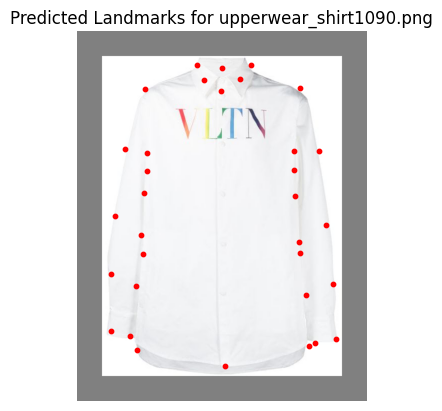


0: 224x192 1 long sleeve top, 34.4ms
Speed: 0.9ms preprocess, 34.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


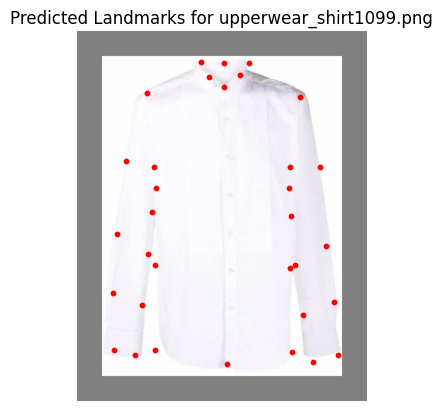


0: 224x192 1 long sleeve top, 31.6ms
Speed: 1.1ms preprocess, 31.6ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


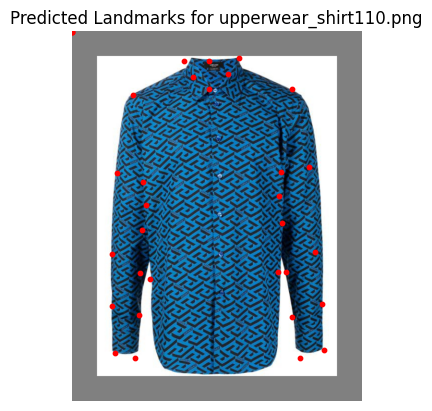


0: 224x192 1 long sleeve top, 36.4ms
Speed: 1.0ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


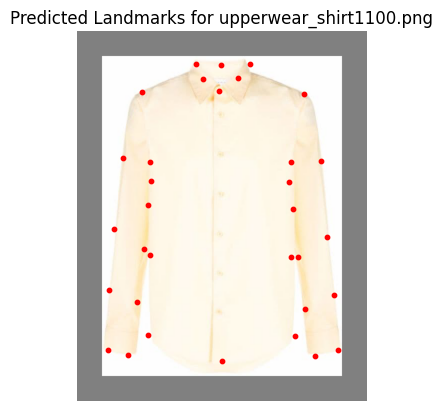

In [18]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Define paths
model_path = '/kaggle/input/model_long_sleeve_top/pytorch/50/1/best(32).pt'
image_dir = '/kaggle/input/outfititems/val/val/upperwear/shirt'

# Get the list of image files
image_files = [
    "upperwear_shirt1004.png",
    "upperwear_shirt1007.png",
    "upperwear_shirt1014.png",
    "upperwear_shirt1024.png",
    "upperwear_shirt1043.png",
    "upperwear_shirt1046.png",
    "upperwear_shirt1063.png",
    "upperwear_shirt1074.png",
    "upperwear_shirt1077.png",
    "upperwear_shirt1090.png",
    "upperwear_shirt1099.png",
    "upperwear_shirt110.png",
    "upperwear_shirt1100.png",
]

# Load the YOLO model
model = YOLO(model_path)

# Define the background color (grey)
grey_color = (128, 128, 128)

# Predict and visualize the results for the images
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    
    # Load image
    img = cv2.imread(image_path)
    
    # Create a grey background
    grey_background = cv2.copyMakeBorder(img, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=grey_color)
    
    # Run the YOLO model on the image with the grey background
    results = model(grey_background)[0]
    
    # Visualize the results
    plt.figure()
    plt.imshow(cv2.cvtColor(grey_background, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    
    for result in results:
        for keypoint in result.keypoints.data.tolist()[0]:
            plt.scatter(keypoint[0], keypoint[1], s=10, c='red', marker='o')  # Plot the keypoints
    
    plt.title(f'Predicted Landmarks for {image_file}')
    plt.axis('off')
    plt.show()



0: 224x192 1 short sleeve outwear, 39.0ms
Speed: 1.1ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


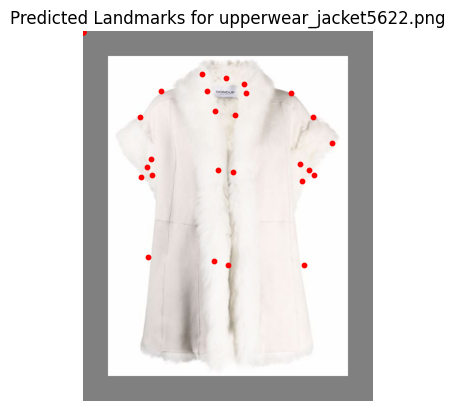


0: 224x192 1 short sleeve outwear, 31.9ms
Speed: 0.9ms preprocess, 31.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


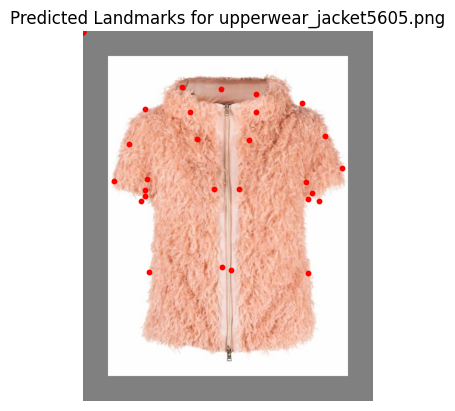


0: 224x192 1 short sleeve outwear, 32.7ms
Speed: 1.1ms preprocess, 32.7ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


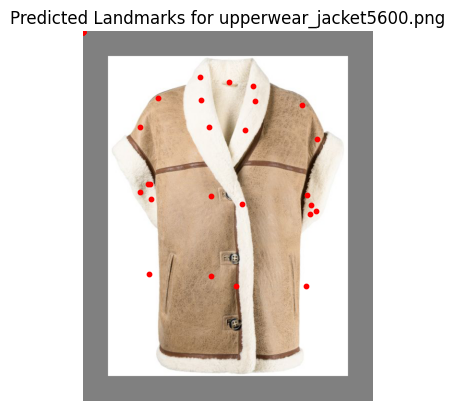


0: 224x192 1 short sleeve outwear, 35.8ms
Speed: 2.4ms preprocess, 35.8ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


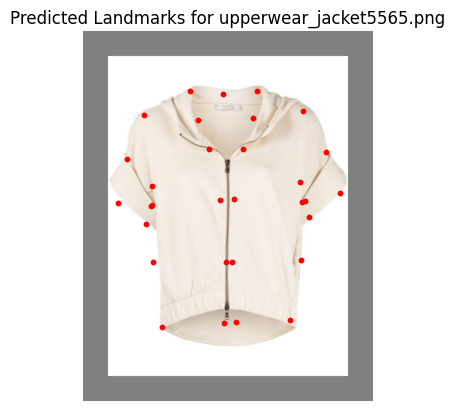


0: 224x192 1 short sleeve outwear, 36.0ms
Speed: 2.8ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


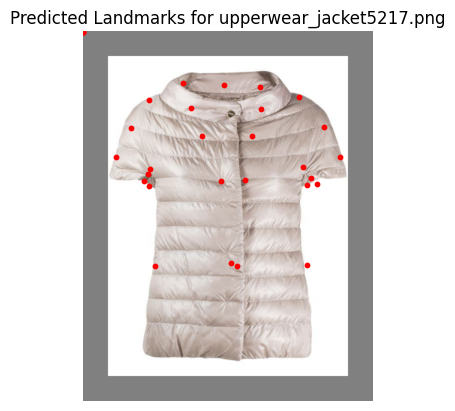


0: 224x192 1 short sleeve outwear, 34.7ms
Speed: 1.1ms preprocess, 34.7ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


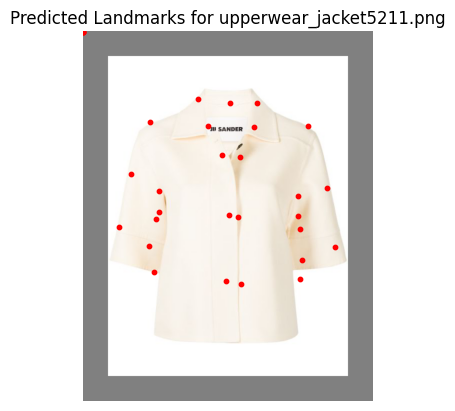


0: 224x192 1 short sleeve outwear, 35.2ms
Speed: 1.0ms preprocess, 35.2ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 192)


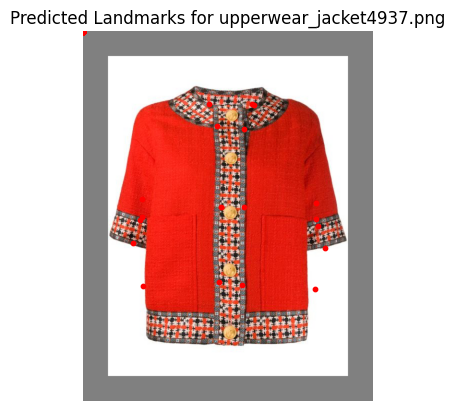


0: 224x192 1 short sleeve outwear, 34.6ms
Speed: 0.9ms preprocess, 34.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


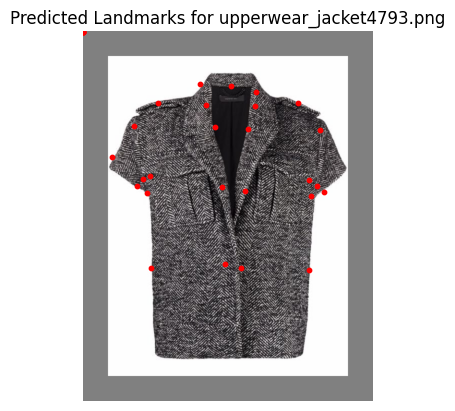

In [5]:
from ultralytics import YOLO
# Define paths
# Define paths
model_path = '/kaggle/input/model_first/pytorch/500/1/best(39).pt'
image_dir = '/kaggle/input/outfititems/train/train/upperwear/jacket'

# Get the list of image files
image_files = [
    "upperwear_jacket5622.png",
    "upperwear_jacket5605.png",
    "upperwear_jacket5600.png",
    "upperwear_jacket5565.png",
    "upperwear_jacket5217.png",
    "upperwear_jacket5211.png",
    "upperwear_jacket4937.png",
    "upperwear_jacket4793.png"
 
]


# Load the YOLO model
model = YOLO(model_path)

# Define the background color (grey)
grey_color = (128, 128, 128)

# Predict and visualize the results for the images
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    
    # Load image
    img = cv2.imread(image_path)
    
    # Create a grey background
    grey_background = cv2.copyMakeBorder(img, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=grey_color)
    
    # Run the YOLO model on the image with the grey background
    results = model(grey_background)[0]
    
    # Visualize the results
    plt.figure()
    plt.imshow(cv2.cvtColor(grey_background, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    
    for result in results:
        for keypoint in result.keypoints.data.tolist()[0]:
            plt.scatter(keypoint[0], keypoint[1], s=10, c='red', marker='o')  # Plot the keypoints
    
    plt.title(f'Predicted Landmarks for {image_file}')
    plt.axis('off')
    plt.show()



image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/104.png: 224x160 1 vest dress, 142.7ms
Speed: 9.6ms preprocess, 142.7ms inference, 21.0ms postprocess per image at shape (1, 3, 224, 160)


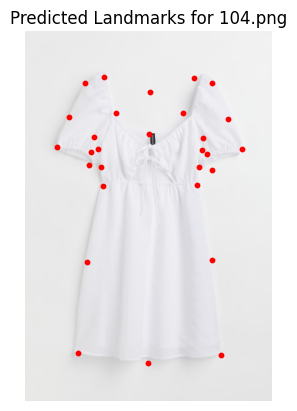


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/041c6bde-e737-46fd-9586-984c1503941f.jpg: 224x192 1 vest dress, 43.2ms
Speed: 0.7ms preprocess, 43.2ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 192)


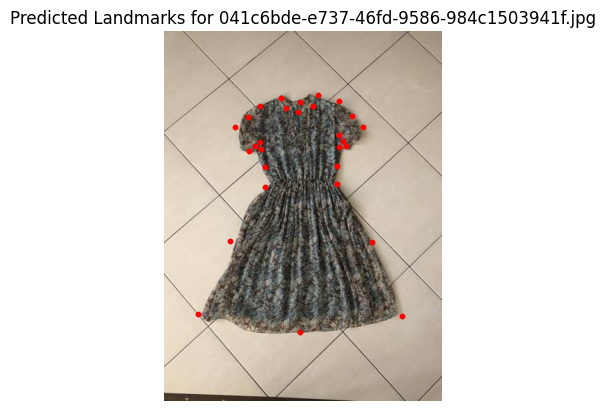


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/116.png: 224x160 1 vest dress, 31.6ms
Speed: 0.7ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 160)


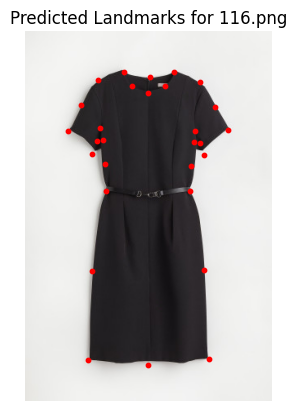


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/129.png: 224x160 1 vest dress, 31.5ms
Speed: 0.8ms preprocess, 31.5ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


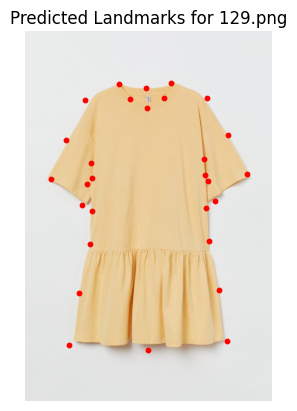


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/134.png: 224x160 1 vest dress, 28.1ms
Speed: 0.7ms preprocess, 28.1ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


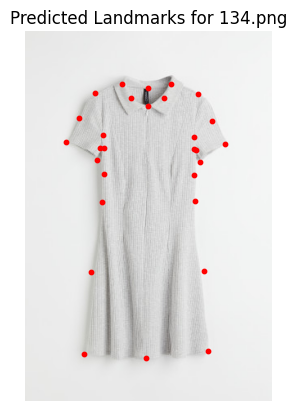


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/140.png: 224x160 1 vest dress, 30.4ms
Speed: 0.7ms preprocess, 30.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 160)


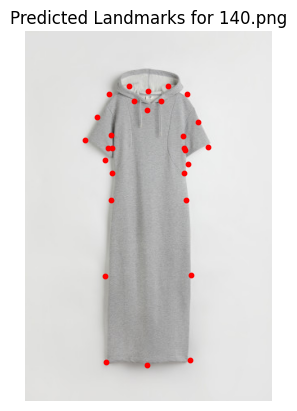


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/147.png: 224x160 1 vest dress, 28.9ms
Speed: 0.7ms preprocess, 28.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


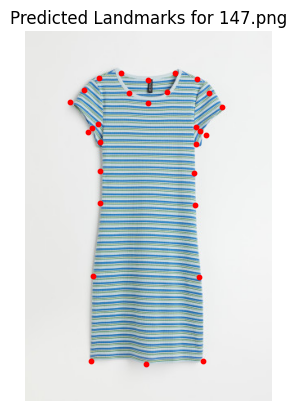


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/15.png: 224x160 1 vest dress, 28.2ms
Speed: 0.7ms preprocess, 28.2ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


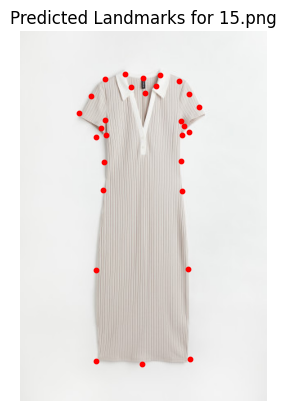


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/16740066-3329-4165-884a-25c42814d590.jpg: 224x224 1 vest dress, 43.9ms
Speed: 0.8ms preprocess, 43.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)


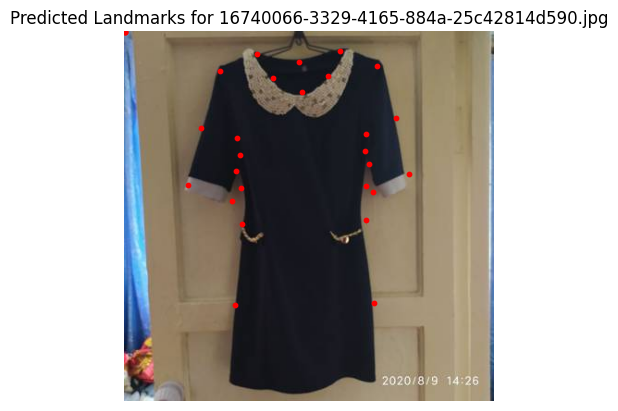


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/162.png: 224x160 1 vest dress, 28.2ms
Speed: 0.7ms preprocess, 28.2ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 160)


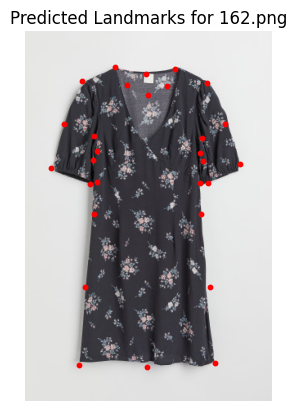

In [4]:
from ultralytics import YOLO
# Define paths
model_path = '/kaggle/input/model_short_sleeve_dress/pytorch/70_epoch/1/best(21).pt'
image_dir = '/kaggle/input/outfititems/train/train/one-piece/dress'

# Get the list of image files
image_files = [

    "104.png",
    "041c6bde-e737-46fd-9586-984c1503941f.jpg",

    "116.png",
    "129.png",
    "134.png",
    "140.png",
    "147.png",
    "15.png",
    "16740066-3329-4165-884a-25c42814d590.jpg",
    "162.png"
 
]

# Load the YOLO model
model = YOLO(model_path)

# Predict and visualize the results for the first 10 images
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    
    # Load image
    img = cv2.imread(image_path)
    
    # Run the YOLO model
    results = model(image_path)[0]
    
    # Visualize the results
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    
    for result in results:
        for keypoint in result.keypoints.data.tolist()[0]:
            plt.scatter(keypoint[0], keypoint[1], s=10, c='red', marker='o')  # Plot the keypoints
    
    plt.title(f'Predicted Landmarks for {image_file}')
    plt.axis('off')
    plt.show()

In [ ]:
from ultralytics import YOLO
# Define paths
model_path = '/kaggle/input/model_skirt/pytorch/50_epoch/1/best(15).pt'
image_dir = '/kaggle/input/outfititems/train/train/bottomwear/skirt'

# Get the list of image files
image_files = [
    "011ecf12-aab1-4c72-8f77-2649386cd23b.jpg",
    "02341619-2fa3-42d4-bb5e-689518228e67.jpg",
    "038e4976-e75f-452e-bccc-2ebb5d5c0e0a.jpg",
    "0570064d-b6cf-48a5-a703-f217d8a38333.jpg",
    "085469ab-cdb6-42e6-a3cf-f370b6b6ddd6.jpg",
    "0903f4c9-a877-4832-bb9e-2a4f4b8f7f67.jpg",
    "0ab26941-211e-44d7-a62a-20207fa7a3e0.jpg",
    "0ba71e2a-4941-4c09-952e-e32895840d34.jpg",
    "0da586b0-bbfb-44fd-a629-12aee2b1d430.jpg",
    "0f8c39ba-e2b1-4c94-be5e-6ac2d924f7ed.jpg",
    "1.png",
    "10.png",
    "104b1054-3d95-4738-8199-d4b0581e735f.jpg",
    "12.png",
    "13.png",
    "20.png",
    "15.png",
    "16.png",
    "22.png",
    "18.png",
    "21.png",
    "23.png",
    "25.png",
]

# Load the YOLO model
model = YOLO(model_path)

# Predict and visualize the results for the first 10 images
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    
    # Load image
    img = cv2.imread(image_path)
    
    # Run the YOLO model
    results = model(image_path)[0]
    
    # Visualize the results
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    
    for result in results:
        for keypoint in result.keypoints.data.tolist()[0]:
            plt.scatter(keypoint[0], keypoint[1], s=10, c='red', marker='o')  # Plot the keypoints
    
    plt.title(f'Predicted Landmarks for {image_file}')
    plt.axis('off')
    plt.show()


# preparing data for the classification task
Because the data contains some images with multiple items, which can confuse the classification model, I filtered out only the images that contain a single category

In [ ]:
import os
import shutil
import pandas as pd

# Load the DataFrame for train and validation
train_csv = '/kaggle/input/data-resi/input/train.csv'  # Replace with the path to your train CSV file
val_csv = '/kaggle/input/data-resi/input/validation.csv'  # Replace with the path to your validation CSV file

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

# Update paths in the 'path' column
new_base_path_train = '/kaggle/input/data-resi/resized/train'
train_df['path'] = train_df['path'].apply(lambda x: os.path.join(new_base_path_train, os.path.basename(x)))

new_base_path_val = '/kaggle/input/data-resi/resized/validation'
val_df['path'] = val_df['path'].apply(lambda x: os.path.join(new_base_path_val, os.path.basename(x)))

# Filter out images that belong to multiple categories
def filter_single_category_images(df):
    # Identify paths that belong to more than one category
    duplicate_paths = df[df.duplicated('path', keep=False)]
    
    # Filter out images with duplicate paths
    filtered_df = df[~df['path'].isin(duplicate_paths['path'])]
    return filtered_df

train_df = filter_single_category_images(train_df)
val_df = filter_single_category_images(val_df)

# Define the base path where the data directory will be created
base_path = '/kaggle/working/'

# Create directory structure
def create_directory_structure(base_path, categories):
    train_path = os.path.join(base_path, 'train')
    val_path = os.path.join(base_path, 'val')
    
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    
    for category in categories:
        os.makedirs(os.path.join(train_path, category), exist_ok=True)
        os.makedirs(os.path.join(val_path, category), exist_ok=True)

# Copy images to directories
def copy_images_to_directories(df, base_path, dataset_type):
    categories = df['category_name'].unique()
    create_directory_structure(base_path, categories)
    
    for category in categories:
        category_df = df[df['category_name'] == category]
        images = category_df['path'].tolist()
        
        category_path = os.path.join(base_path, dataset_type, category)
        
        for img in images:
            # Double-check that the image belongs to the correct category
            if os.path.exists(img):
                shutil.copy(img, category_path)
            else:
                print(f"Image {img} not found and was skipped.")

# Copy images to the appropriate directories
copy_images_to_directories(train_df, base_path, 'train')
copy_images_to_directories(val_df, base_path, 'val')

# classification model training 

In [ ]:

import os

from ultralytics import YOLO
DATA_DIR='/kaggle/input/data-aug'
# Load a model
model = YOLO("yolov8n-cls.pt")  # load a pretained model

# Use the model
results = model.train(data=DATA_DIR, epochs=50, imgsz=224)  # train the model

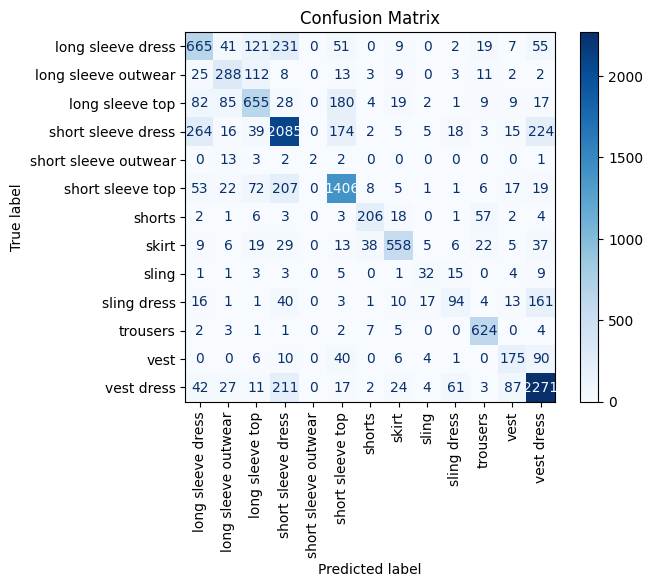

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ultralytics import YOLO
import contextlib 

# Load the model
model = YOLO("/kaggle/input/tes_clasi/pytorch/50_epoch/1/best(43).pt")

# Explicit category-to-label mapping based on training
category_to_label = {
    'long sleeve dress': 0,
    'long sleeve outwear': 1,
    'long sleeve top': 2,
    'short sleeve dress': 3,
    'short sleeve outwear': 4,
    'short sleeve top': 5,
    'shorts': 6,
    'skirt': 7,
    'sling': 8,
    'sling dress': 9,
    'trousers': 10,
    'vest': 11,
    'vest dress': 12
}

# Reverse the mapping to get labels from index
label_to_category = {v: k for k, v in category_to_label.items()}

# Directories
val_data_dir = '/kaggle/input/data-hope/val'

# Initialize lists for predictions and true labels
predictions = []
true_labels = []

# Iterate over categories
for category, true_class in category_to_label.items():
    category_dir = os.path.join(val_data_dir, category)
    images = [os.path.join(category_dir, fname) for fname in os.listdir(category_dir) if fname.endswith('.jpg')]
    
    for img_path in images:
        # Suppress output during prediction
        with contextlib.redirect_stdout(None), contextlib.redirect_stderr(None):
            results = model.predict(source=img_path, verbose=False)  # Ensure verbose=False to minimize output
        
        # Check if results are valid
        if results and len(results) > 0:
            # Extract the top prediction class index
            pred_class = int(results[0].probs.top1)
            
            predictions.append(pred_class)
            true_labels.append(true_class)

# Convert lists to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute confusion matrix using the correct labels order
labels = sorted(category_to_label.values())
cm = confusion_matrix(true_labels, predictions, labels=labels)

# Plot and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_to_category[label] for label in labels])
disp.plot(cmap=plt.cm.Blues)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()





After training for 50 epochs, the model's results are: top-1 accuracy = 0.74 and top-5 accuracy = 0.98.

# the measurement task

simple exemple of measurment 

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load YOLO model and image
model_path = '/kaggle/input/model_skirt/pytorch/50_epoch/1/best(15).pt'
image_path = '/kaggle/input/outfititems/train/train/bottomwear/skirt/22.png'
model = YOLO(model_path)
img = cv2.imread(image_path)
results = model(image_path)[0]

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Get the predicted keypoints on the clothing item
keypoints = results.keypoints.data.tolist()[0]

# Get image dimensions
image_height, image_width, _ = img.shape

# Known physical dimensions of the table (background)
table_width_m = 0.8  # Width in meters
table_height_m = 0.8  # Height in meters

# Calculate the scaling factors (pixels per meter)
scaling_factor_width = table_width_m / image_width
scaling_factor_height = table_height_m / image_height

# Display the image with keypoints
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Keypoints on the clothing item')

# Plot the predicted keypoints
for i, (x, y, v) in enumerate(keypoints):
    if v > 0:  # Only plot visible keypoints
        ax.plot(x, y, 'bo')  # Mark the keypoint
        ax.text(x, y, f'{i}', color='blue', fontsize=12, ha='right')

plt.show()

# Input widget to enter pairs of indices
input_pairs = widgets.Text(description="Pairs (e.g., 0,1 2,3):")
display(input_pairs)

# Button to calculate distances
calculate_button = widgets.Button(description="Calculate Distances")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        pairs = input_pairs.value.split()
        for pair in pairs:
            i, j = map(int, pair.split(','))
            point1 = (int(keypoints[i][0]), int(keypoints[i][1]))
            point2 = (int(keypoints[j][0]), int(keypoints[j][1]))
            pixel_distance = euclidean_distance(point1, point2)
            physical_distance = pixel_distance * np.mean([scaling_factor_width, scaling_factor_height])
            cv2.line(img, point1, point2, (255, 0, 0), 2)  # Draw line between keypoints
            mid_point = ((point1[0] + point2[0]) // 2, (point1[1] + point2[1]) // 2)

            # Add background rectangle for text
            (text_width, text_height), _ = cv2.getTextSize(f"{physical_distance:.2f} m", cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            box_coords = ((mid_point[0] - 5, mid_point[1] + 5), (mid_point[0] + text_width + 5, mid_point[1] - text_height - 5))
            cv2.rectangle(img, box_coords[0], box_coords[1], (0, 0, 0), cv2.FILLED)

            # Add text
            cv2.putText(img, f"{physical_distance:.2f} m", mid_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Visualize the results
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
        plt.title('Selected Points with Measurements')
        plt.axis('off')
        plt.show()

calculate_button.on_click(on_button_clicked)
display(calculate_button, output)


the entire code 


image 1/1 /kaggle/input/outfititems/test/test/upperwear/tshirt/172950bd-f639-4ce5-bc55-d17cea7b9705.jpg: 224x224 short sleeve top 0.76, short sleeve dress 0.23, long sleeve dress 0.00, long sleeve top 0.00, vest 0.00, 12.2ms
Speed: 4.3ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/outfititems/test/test/upperwear/tshirt/172950bd-f639-4ce5-bc55-d17cea7b9705.jpg: 224x192 1 short sleeve top, 35.4ms
Speed: 0.8ms preprocess, 35.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 192)


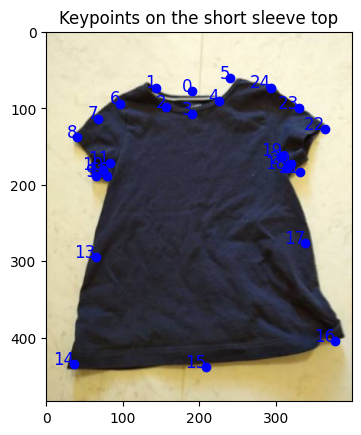

Text(value='', description='Pairs (e.g., 0,1 2,3):')

Button(description='Calculate Distances', style=ButtonStyle())

Output()


image 1/1 /kaggle/input/outfititems/test/test/upperwear/tshirt/259f2358-fb94-4e7e-bd05-864e28071c17.jpg: 224x224 short sleeve top 0.97, short sleeve dress 0.02, long sleeve top 0.01, long sleeve dress 0.00, vest dress 0.00, 14.0ms
Speed: 6.6ms preprocess, 14.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/outfititems/test/test/upperwear/tshirt/259f2358-fb94-4e7e-bd05-864e28071c17.jpg: 224x192 1 short sleeve top, 35.5ms
Speed: 0.7ms preprocess, 35.5ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 192)


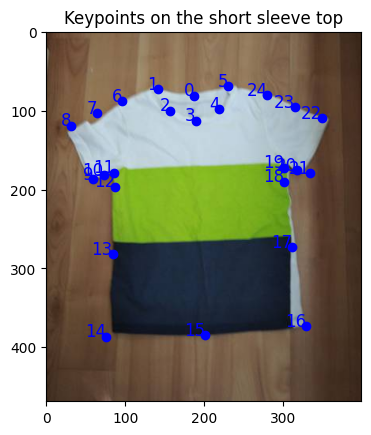

Text(value='', description='Pairs (e.g., 0,1 2,3):')

Button(description='Calculate Distances', style=ButtonStyle())

Output()


image 1/1 /kaggle/input/outfititems/train/train/bottomwear/skirt/12.png: 224x224 skirt 0.81, shorts 0.12, long sleeve top 0.02, vest dress 0.02, trousers 0.01, 13.9ms
Speed: 5.3ms preprocess, 13.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/outfititems/train/train/bottomwear/skirt/12.png: 224x160 1 skirt, 32.1ms
Speed: 0.7ms preprocess, 32.1ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 160)


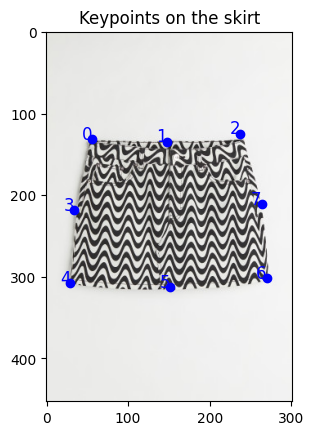

Text(value='', description='Pairs (e.g., 0,1 2,3):')

Button(description='Calculate Distances', style=ButtonStyle())

Output()


image 1/1 /kaggle/input/outfititems/train/train/bottomwear/skirt/10.png: 224x224 skirt 0.59, shorts 0.24, long sleeve top 0.06, trousers 0.04, short sleeve top 0.03, 13.8ms
Speed: 4.2ms preprocess, 13.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/outfititems/train/train/bottomwear/skirt/10.png: 224x160 1 skirt, 30.0ms
Speed: 0.6ms preprocess, 30.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 160)


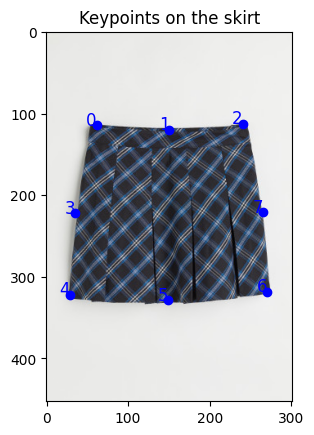

Text(value='', description='Pairs (e.g., 0,1 2,3):')

Button(description='Calculate Distances', style=ButtonStyle())

Output()


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/104.png: 224x224 short sleeve dress 0.96, long sleeve dress 0.03, sling dress 0.01, short sleeve top 0.00, vest dress 0.00, 13.8ms
Speed: 4.2ms preprocess, 13.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/104.png: 224x160 1 vest dress, 33.5ms
Speed: 0.6ms preprocess, 33.5ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 160)


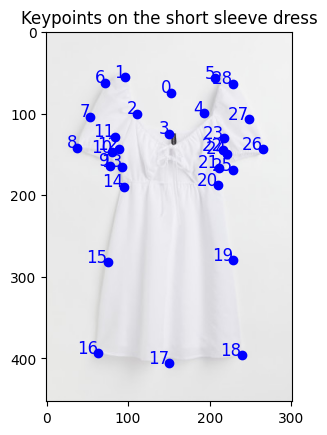

Text(value='', description='Pairs (e.g., 0,1 2,3):')

Button(description='Calculate Distances', style=ButtonStyle())

Output()


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/134.png: 224x224 short sleeve dress 0.86, short sleeve top 0.13, long sleeve dress 0.00, short sleeve outwear 0.00, long sleeve top 0.00, 16.0ms
Speed: 4.3ms preprocess, 16.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/134.png: 224x160 1 vest dress, 31.6ms
Speed: 0.5ms preprocess, 31.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 160)


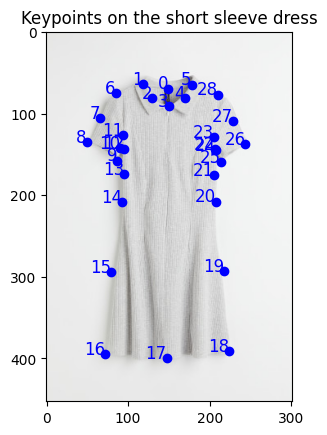

Text(value='', description='Pairs (e.g., 0,1 2,3):')

Button(description='Calculate Distances', style=ButtonStyle())

Output()


image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/041c6bde-e737-46fd-9586-984c1503941f.jpg: 224x224 short sleeve dress 1.00, vest dress 0.00, long sleeve dress 0.00, sling dress 0.00, short sleeve top 0.00, 14.2ms
Speed: 5.2ms preprocess, 14.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/outfititems/train/train/one-piece/dress/041c6bde-e737-46fd-9586-984c1503941f.jpg: 224x192 1 vest dress, 37.0ms
Speed: 0.7ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 192)


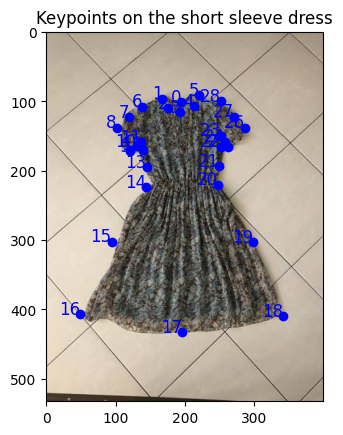

Text(value='', description='Pairs (e.g., 0,1 2,3):')

Button(description='Calculate Distances', style=ButtonStyle())

Output()

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import os

# Define paths to your classification and landmark models
classification_model_path = '/kaggle/input/tes_clasi/pytorch/50_epoch/1/best(43).pt'
landmark_models = {
    'long sleeve dress': '/kaggle/input/model_long_sleeve_dress/pytorch/100_epoch/1/best(24).pt',
    'long sleeve outwear': '/kaggle/input/model_long_sleeve_outwear/pytorch/100/1/best(37).pt',
    'long sleeve top': '/kaggle/input/model_long_sleeve_top/pytorch/50/1/best(32).pt',
    'short sleeve outwear': '/kaggle/input/model_first/pytorch/500/1/best(39).pt',
    'short sleeve dress': '/kaggle/input/model_short_sleeve_dress/pytorch/70_epoch/1/best(21).pt',
    'short sleeve top': '/kaggle/input/model_short_sleeve_top/pytorch/50_epoch/1/best(36).pt',
    'shorts': '/kaggle/input/model_shorts/pytorch/50_epoch_0.01/1/best(13).pt',
    'skirt': '/kaggle/input/model_skirt/pytorch/50_epoch/1/best(15).pt',
    'sling': '/kaggle/input/model_sling/pytorch/300_epoch/1/best(40).pt',
    'sling_dress': '/kaggle/input/model_sling_dress/pytorch/default/1/best(29).pt',
    'trousers': '/kaggle/input/model_trouser/pytorch/model_trousers_50/1/best(8).pt',
    'vest': '/kaggle/input/model_vest/pytorch/default/1/best(33).pt',
    'vest_dress': '/kaggle/input/model_vest_dress/pytorch/50_epoch/1/best(18).pt',
}


# Load the classification model
classification_model = YOLO(classification_model_path)

# Function to classify the image and choose the appropriate model
def classify_and_select_model(image_path):
    # Get classification results
    classification_result = classification_model(image_path)[0]
    
    # Extract the index of the top class
    top1_index = classification_result.probs.top1
    
    # Map the index to the class name
    top1_class = classification_result.names[top1_index]
    
    # Load the corresponding landmark model
    landmark_model_path = landmark_models.get(top1_class)
    
    if not landmark_model_path:
        raise ValueError(f"No landmark model found for class {top1_class}")
    
    return top1_class, YOLO(landmark_model_path)

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Function to measure landmarks for an image
def measure_landmarks(image_path):
    predicted_class, model = classify_and_select_model(image_path)
    img = cv2.imread(image_path)
    results = model(image_path)[0]

    # Get the predicted keypoints on the clothing item
    keypoints = results.keypoints.data.tolist()[0]

    # Get image dimensions
    image_height, image_width, _ = img.shape

    # Known physical dimensions of the table (background)
    table_width_m = 0.6  # Width in meters
    table_height_m = 0.6  # Height in meters

    # Calculate the scaling factors (pixels per meter)
    scaling_factor_width = table_width_m / image_width
    scaling_factor_height = table_height_m / image_height

    # Display the image with keypoints
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Keypoints on the {predicted_class}')

    # Plot the predicted keypoints
    for i, (x, y, v) in enumerate(keypoints):
        if v > 0:  # Only plot visible keypoints
            ax.plot(x, y, 'bo')  # Mark the keypoint
            ax.text(x, y, f'{i}', color='blue', fontsize=12, ha='right')

    plt.show()

    return img, keypoints, scaling_factor_width, scaling_factor_height

# Function to calculate and display distances between selected points
def calculate_distances(img, keypoints, scaling_factor_width, scaling_factor_height, pairs):
    for pair in pairs:
        i, j = pair
        point1 = (int(keypoints[i][0]), int(keypoints[i][1]))
        point2 = (int(keypoints[j][0]), int(keypoints[j][1]))
        pixel_distance = euclidean_distance(point1, point2)
        physical_distance = pixel_distance * np.mean([scaling_factor_width, scaling_factor_height])
        cv2.line(img, point1, point2, (255, 0, 0), 2)  # Draw line between keypoints
        mid_point = ((point1[0] + point2[0]) // 2, (point1[1] + point2[1]) // 2)

        # Add background rectangle for text
        (text_width, text_height), _ = cv2.getTextSize(f"{physical_distance:.2f} m", cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        box_coords = ((mid_point[0] - 5, mid_point[1] + 5), (mid_point[0] + text_width + 5, mid_point[1] - text_height - 5))
        cv2.rectangle(img, box_coords[0], box_coords[1], (0, 0, 0), cv2.FILLED)

        # Add text
        cv2.putText(img, f"{physical_distance:.2f} m", mid_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Visualize the results
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title('Selected Points with Measurements')
    plt.axis('off')
    plt.show()

import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to handle user input and calculate distances for an image
def measure_with_user_input(image_path):
    # Measure landmarks and get necessary information
    img, keypoints, scaling_factor_width, scaling_factor_height = measure_landmarks(image_path)
    
    # Input widget for user to enter pairs of indices
    input_pairs = widgets.Text(description="Pairs (e.g., 0,1 2,3):")
    display(input_pairs)

    # Button to calculate distances
    calculate_button = widgets.Button(description="Calculate Distances")
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            clear_output()
            pairs = input_pairs.value.split()
            parsed_pairs = []
            for pair in pairs:
                try:
                    i, j = map(int, pair.split(','))
                    parsed_pairs.append((i, j))
                except ValueError:
                    print(f"Invalid input: '{pair}' - Please enter pairs as 'i,j'")
            
            if parsed_pairs:
                calculate_distances(img, keypoints, scaling_factor_width, scaling_factor_height, parsed_pairs)

    calculate_button.on_click(on_button_clicked)
    display(calculate_button, output)

# Example usage for a list of images
directories_and_files = [
    {
        'dir': '/kaggle/input/outfititems/test/test/upperwear/tshirt',
        'files': [
            "172950bd-f639-4ce5-bc55-d17cea7b9705.jpg",
            "259f2358-fb94-4e7e-bd05-864e28071c17.jpg"
        ]
    },
    {
        'dir': '/kaggle/input/outfititems/train/train/bottomwear/skirt',
        'files': [
                "12.png",
                "10.png"
        ]
    },
    {
        'dir': '/kaggle/input/outfititems/train/train/one-piece/dress',
        'files': [
            "104.png",
             "134.png",
            "041c6bde-e737-46fd-9586-984c1503941f.jpg"
        ]
    }
]

# Construct the full image paths
image_paths = []
for entry in directories_and_files:
    image_dir = entry['dir']
    image_files = entry['files']
    image_paths.extend([os.path.join(image_dir, image_file) for image_file in image_files])

for image_path in image_paths:
    measure_with_user_input(image_path)
